#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [2]:
# Функция потерь
def loss(X: np.ndarray,
         y: np.ndarray,
         w: List[float],
         w0: float,
         gamma=1.0,
         beta=1.0) -> float:
    z = np.dot(X, w) + w0
    log_loss = np.log1p(np.exp(-y * z)).mean()
    l1 = gamma * np.abs(w).sum()
    l2 = beta * np.sum(w ** 2)

    return log_loss + l1 + l2


#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
# Функция расчета градиента для логистической регрессии с регуляризацией Elastic Net
def get_grad(X: np.ndarray, y: np.ndarray, w: List[float], w0: float, gamma=1.0, beta=1.0) -> Tuple[List[float], float]:
    z = np.dot(X, w) + w0
    prob = 1 / (1 + np.exp(y*z))

    grad_w = -(X.T @ (y*prob)) / len(y) + gamma * np.sign(w) + 2*beta*w

    grad_w0 = -np.mean(y * prob)

    return grad_w, grad_w0

In [4]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [25]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w = None
        self.w0 = None
        self.loss_logs = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_features = X.shape[1]
        self.w = np.random.randn(n_features)
        self.w0 = 0.0

        for i in range(self.max_iter):
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)

            self.w  -= self.lr * grad_w
            self.w0 -= self.lr * grad_w0

            current_loss = loss(X, y, self.w, self.w0, self.gamma, self.beta)
            self.loss_logs.append(current_loss)

            if np.linalg.norm(grad_w) < self.tolerance and abs(grad_w0) < self.tolerance:
                break

    def predict(self, X):
        return (np.dot(X, self.w) + self.w0 >= 0).astype(int)

    def predict_proba(self, X):
        z = np.dot(X, self.w) + self.w0
        probabilities = 1 / (1 + np.exp(-z))

        return np.vstack([1 - probabilities, probabilities]).T

In [7]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [26]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1


    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    colors=ListedColormap(('green', 'red'))

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=colors)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=colors)
    plt.xlabel("Признак 1")
    plt.ylabel("Признак 2")
    plt.title("Decision Boundary of Logistic Regression Model")
    plt.show()

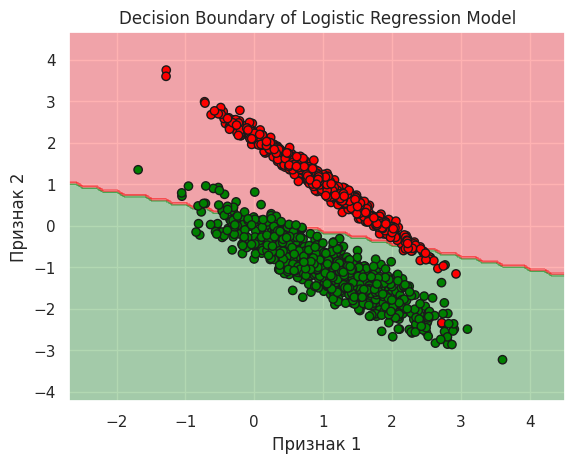

In [27]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [29]:
def plot_loss_history(model):
    plt.plot(model.loss_logs, label="Loss")
    plt.xlabel("Итерация")
    plt.ylabel("Ошибка")
    plt.title("Зависимость величины функции потерь от итерации")
    plt.legend()
    plt.show()

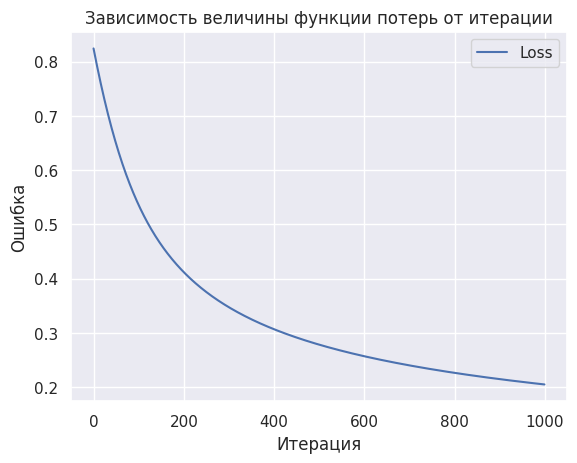

In [30]:
plot_loss_history(model)

#### 6. [2 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [31]:
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    roc_curve
)
from itertools import product

def test_svc(X_train, X_test, y_train, y_test) -> None:
    kernels =  ['linear', 'poly', 'rbf', 'sigmoid']
    C_coefs = [0.1, 0.2, 0.5, 3, 5, 7]

    args = product(kernels, C_coefs)

    y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

    for kernel, C in args:
      svc_model = SVC(kernel=kernel, C=C, probability=True, random_state=42)
      svc_model.fit(X_train, y_train)
      y_pred = svc_model.predict(X_test)

      # Метрики
      accuracy =  accuracy_score(y_test, y_pred)
      precision = precision_score(y_test, y_pred)
      recall =    recall_score(y_test, y_pred)
      f1 =        f1_score(y_test, y_pred)
      auc_roc =   roc_auc_score(y_test_binarized, svc_model.decision_function(X_test), multi_class="ovr")

    print(f"Kernel: {kernel}, C: {C}")
    print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, AUC-ROC: {auc_roc:.2f}")


#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [32]:
from scipy.spatial import distance

class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def get_neighbors(self, X):
        distances = distance.cdist(X, self.X_train, metric=self.metric)
        neighbors_idx = np.argsort(distances, axis=1)[:, :self.n_neighbors]
        return self.y_train[neighbors_idx]

    def predict(self, X):
        neighbors = self.get_neighbors(X)
        return np.array([np.bincount(neigh).argmax() for neigh in neighbors])

    def predict_proba(self, X):
        neighbors = self.get_neighbors(X)
        classes = np.unique(self.y_train)
        probas = []

        for neigh in neighbors:
            counts = np.bincount(neigh, minlength=len(classes))
            probas.append(counts / self.n_neighbors)

        return np.array(probas)


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


df = pd.read_csv('train.csv')

X = df.drop(columns=['Id', 'Category']).values
y = df['Category'].values

X = X[~np.isnan(y)]
y = y[~np.isnan(y)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=15)

#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

In [ ]:
plt.figure(figsize=(10, 10))

for class_id in df['Id'].unique():
  idx = np.where(y == class_id)[0][0]
  plt.subplot(5, 2, class_id + 1)
  plt.imshow(X[idx].reshape(28, 28), cmap='gray')
  plt.axis('off')
plt.show()

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [33]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
# StandartScaler
scaler_standard = StandardScaler()
X_train_standard = scaler_standard.fit_transform(X_train)
X_test_standard = scaler_standard.transform(X_test)

In [ ]:
# MinMaxScaler
scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train)
X_test_minmax = scaler_minmax.transform(X_test)

#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

#### Задача 2. [1 Балл] При классификации Fashion Mnist модель Логистической регрессии на обучении многоклассовой классификации методом One-VS-All у Вас получилось k классификаторов. Изобразите веса ваших полученных моделей как изображения в matplotlib. Возможно, модель выучила какие-то графические паттерны в данных? Ответ обоснуйте.

#### Задача 3. [1 Балл] В задаче классификации Fashion Mnist Вы попытались выбить какой-то accuracy. Для получения бонусного балла Вам нужно на той же самой выборке получить значение метрики accuracy > 0.87 на тесте (Тестовую выборку менять нельзя, но обучающую можно). Какими моделями и методами Вы это будете делать - на Ваше усмотрение, но **нельзя использовать никакие нейронные сети**. Необходимо получить модель машинного обучения, выполняющую эту задачу.